# Localization

In this tutorial we'll estimate the localization of a source based on a classical maximum likelihood estimate (MLE) method. 

The key class is `TSMap` which generates a test statistics map based on one or more objects of the `LocLike` class. All derived classes of `LocLike` provide the likelihood for a given coordinate through the `get_log_like` method. This allows multiple instruments to participate in a joint fit by creating an appropiate `LocLike` subclass.

For this example we'll use the simple `NormLocLike` subclass, which defines the Poisson likelihood for a photon-counting experiment as

$$
\log \mathcal{L}(N) = \sum_i \log P(\lambda = b_i + N e_i; d_i) = \sum_i \log \frac{\lambda^{d_i} e^\lambda}{d_i!} , 
$$

where

- $d_i$ are the set of counts detected by each detector
- $b_i$ are the estimated background counts
- $e_i$ are the estimated excess counts for a given hypothesis
- $N$, the only free parameter, is the overall normalization.

We proceed to use a full instrument response file to compute the estimated excess counts `e_i` based on a fiducial 1s burst with an index -2 power law spectrum:

In [3]:
import bctools.data as data
from bctools.io import InstrumentResponse
from bctools.loc import LocalLocTable
from bctools.spectra.spectrum import PowerLaw

# Convolve an full instrument response with a hypothetical spectrum
irf_path = data.path/'sims/drm.h5'

with InstrumentResponse(irf_path) as irf: 
    
    # Hypothetical spectrum
    # This normalization corresponds to 1 ph/cm2/s between 50-300 keV
    spectrum = PowerLaw(60, 2)
    
    # In this case we integrate the rate from all energy channels. 
    # You can subdivide the data into multiple energy channel groups
    local_loctable = LocalLocTable.from_irf(irf, spectrum)
    
# The local_loctable contains the expected rates in spacecraft coordinates
# We now need to use this to estimate the total expected counts in sky coordinate for
# the full duration of an event. 
# In this case we simply have a 1 second event and specifying the attitude by a quaternion
# ([0,0,0,1] corresponds to the identity rotation). You can have multiple attitude-duration
# pairs to correctly model long duration events.
sky_loctable = local_loctable.to_skyloctable(attitude = [0,0,0,1], duration = 1)

Here's how the look-up tables in `norm_likelihood` look. Note that we're using a low-resolution instrument response. Although these tables are bilinearly interpolated, you typically need a resolution comparable to the localization uncertainty you expect.

Look-up tables: ['SQD0' 'SQD1' 'SQD2' 'SQD3']


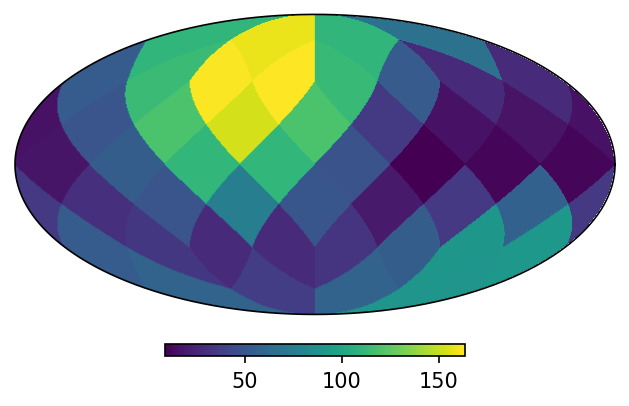

In [2]:
print(f"Look-up tables: {sky_loctable.labels}")

sky_loctable.get_expectation_map('SQD0').plot();

Now that we have the expected excessthe remaining ingredients are the actual measured counts and their corresponding estimated background counts. For real event these come from data. In this case we'll simulate a background rate of 1 kHz per detector and a source of 2 ph/cm2/s at (RA = 60deg, Dec = 45deg)

In [4]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# 1 kHz per detector (we're simulating a 1s burst)
bkg = [1000, 1000, 1000, 1000]
sky_loctable.set_background(bkg)

# Injected source location
coord = SkyCoord(ra = 60*u.deg, dec = 45*u.deg)

# 2 ph/cm2/s between 50-300 keV (our hypothetital source was 1 ph/cm2/s)
signal = 2*sky_loctable.get_expectation(coord)

sky_loctable.set_data(bkg + signal)

With all the ingredients in place, we can now compute a test-statistics map: 

In [5]:
from bctools.loc import TSMap, NormLocLike

# NormLocLike is a subclass of LocLike and computes
# a Poisson likelihood for counting instruments. The
# overall normalization is the only free parameter
norm_likelihood = NormLocLike(sky_loctable)

# Define a map of nside = 32. Note that this is a finer resolution
# that the underlying look-up table, which will be interpolated
ts = TSMap(nside = 32, coordsys = 'icrs')

# Compute the TS map from one or more LocLikelihood
ts.compute(norm_likelihood)

These are the results:

Maximum sqrt(TS) = 12.55
Best estimate: RA = 61.50 deg Dec= 44.99 deg
Error area (90% cont.): 1937.09 deg2
Equivalent error radius (90% cont.): 24.83 deg


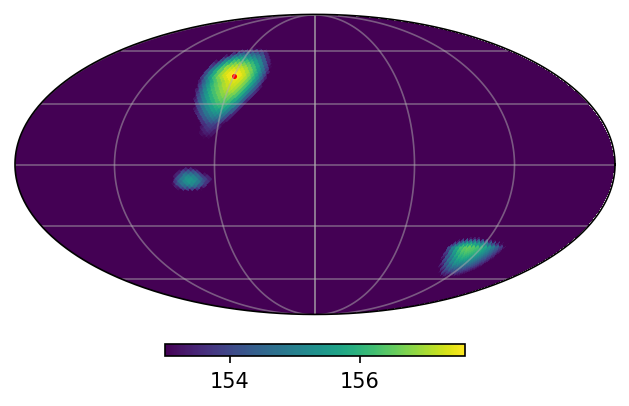

In [6]:
import numpy as np
print(f"Maximum sqrt(TS) = {np.sqrt(np.max(ts)):.2f}")
print(f"Best estimate: RA = {ts.best_loc().ra:.2f} Dec= {ts.best_loc().dec:.2f}")
print(f"Error area (90% cont.): {ts.error_area(cont = .9).to(u.deg**2):.2f}")
print(f"Equivalent error radius (90% cont.): {np.sqrt(ts.error_area(cont = .9)/np.pi).to(u.deg):.2f}")

img,ax = ts.plot()
ax.grid(alpha = .5)

# Actual location of simulated source
ax.scatter(coord.ra.to(u.deg).value, coord.dec.to(u.deg).value, 
           color = 'red', transform = ax.get_transform('world'), s = 2);